In [1]:
import numpy as np
import arms
import matplotlib.pyplot as plt
from tqdm import tqdm

def MAB(probabilities):
    model=[]
    for i in range(len(probabilities)):
        arm=arms.ArmBernoulli(probabilities[i],random_state=np.random.randint(1, 312414))
        model.append(arm)
    return model

In [2]:
model_mab=MAB([0.7,0.9,0.25,0.55])

def UCB1(T,MAB):
    #initialization (drawing each arm once)
    rew=[]
    draws=[]
    for i in range(len(MAB)):
        rew.append(1*MAB[i].sample()[0])
        draws.append(MAB[i])
    
    draw_count=[1]*len(MAB) #number of times that arm[i] was drawn is draw_count[i]
    #Choosing arm
    #time horizon max T
    #empirical mean of the rewards observed by pulling an arm j
    while(i<T-1):
        ucb=[]
        
        for j in range(len(MAB)):
            
            s=0
            emp_sum=0
            for k in range(len(draws)):
                if (MAB[j]==draws[k]):
                    s+=1
                    emp_sum+=rew[k]
            ucb.append(emp_sum/s+np.sqrt(3*np.log(i)/(2*(draw_count[j]))))
        draws.append(MAB[np.argmax(ucb)])
        rew.append(1*MAB[np.argmax(ucb)].sample()[0])
        draw_count[np.argmax(ucb)]+=1
        i=i+1
    return [rew,draws]    

In [4]:
rew1,draws1=UCB1(5000,model_mab)

for j in range(len(model_mab)):        
    for k in range(len(draws1)):
        if (model_mab[j]==draws1[k]):
            draws1[k]=j

### This is complicated, we should change the way we define draws (here we're appending the arms directly, we can append the number of the arm which is equivalent and we won't have to do a loop to know how many times an arm was pulled.)

In [6]:
def UCB1(T,MAB,ro):
    rew=[]
    draws=[]
    N=np.array([0]*len(MAB))
    S=[0]*len(MAB)
    k=0
    while(k<len(MAB)):
        r=1*MAB[k].sample()[0]
        draws.append(k)
        rew.append(r)
        S[k]+=float(r)
        N[k]+=1
        k+=1
    score=S/N+ro*np.sqrt(np.log(k-1)/2*N)
    for p in range(k,T):
        a=np.argmax(score)
        r=1*MAB[a].sample()[0]
        draws.append(a)
        rew.append(r)
        S[a]+=float(r)
        N[a]+=1
        score=S/N+ro*np.sqrt(np.log(p)/2*N)
    return [rew,draws]
rew1,draws1=UCB1(5000,model_mab,np.sqrt(3))

In [7]:
def TS(T,MAB):
    rew=[]
    draws=[]
    N=np.array([0]*len(MAB))
    S=[0]*len(MAB)
    for k in range(T):
        A=[np.random.beta(S[a]+1,N[a]-S[a]+1) for a in range(len(MAB))]
        a=np.argmax(A)
        r=1*MAB[a].sample()[0]
        draws.append(a)
        rew.append(r)
        N[a]+=1
        S[a]+=r
    return [rew,draws]
def Naive(T,MAB):
    rew=[]
    draws=[]
    N=np.array([0]*len(MAB))
    S=[0]*len(MAB)
    k=0
    while(k<len(MAB)):
        r=1*MAB[k].sample()[0]
        draws.append(k)
        rew.append(r)
        S[k]+=float(r)
        N[k]+=1
        k+=1
    score=S/N
    for p in range(k,T):
        a=np.argmax(score)
        r=1*MAB[a].sample()[0]
        draws.append(a)
        rew.append(r)
        S[a]+=float(r)
        N[a]+=1
        score=S/N
    return [rew,draws]

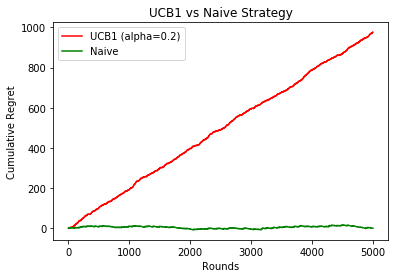

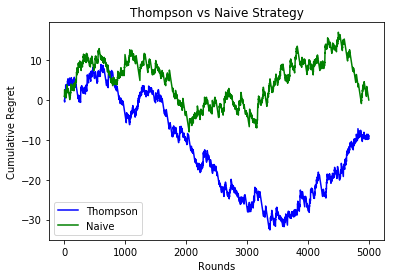

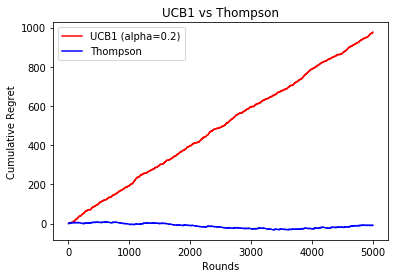

In [8]:
T=5000
nb_arms=len(model_mab)
means=[el.mean for el in model_mab]
mu_max=np.max(means)

#Cumulative expected regret UCB1, Thompson Samplng and Naive strategy
[rew1,draws1]=UCB1(T, model_mab,np.sqrt(3))
reg1 = mu_max * np.arange(1, T + 1) - np.cumsum(rew1)
[rew2,draws2]=TS(T, model_mab)
reg2 = mu_max * np.arange(1, T + 1) - np.cumsum(rew2)
[rew3,draws3]=Naive(T,model_mab)
reg3 = mu_max * np.arange(1, T + 1) - np.cumsum(rew3)

#Different comparisons
plt.figure(1)
x = np.arange(1, T+1)
plt.plot(x, reg1,c='r', label='UCB1 (alpha=0.2)')
plt.plot(x, reg3,c='g', label='Naive')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('UCB1 vs Naive Strategy')
plt.legend()
plt.show()

plt.figure(2)
x = np.arange(1, T+1)
plt.plot(x, reg2, c='blue', label='Thompson')
plt.plot(x, reg3, c='g', label='Naive')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Thompson vs Naive Strategy')
plt.legend()
plt.show()

plt.figure(3)
x = np.arange(1, T+1)
plt.plot(x, reg1,c='r', label='UCB1 (alpha=0.2)')
plt.plot(x, reg2,c='blue', label='Thompson')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('UCB1 vs Thompson')
plt.legend()
plt.show()

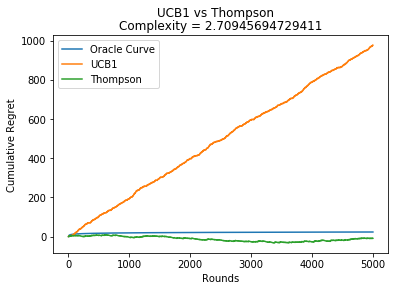

In [9]:
kl = lambda x,y: x*np.log(x/y)+(1-x)*np.log((1-x)/(1-y))


def complexity(p):
    C=0
    p_opt,i_opt=np.max(p),np.argmax(p)
    for i in range(len(model_mab)):
        if (i!=i_opt):
            C+=(p_opt-p[i])/kl(p[i],p_opt)
    return C
p = means
C=complexity(p)

plt.figure(3)
x = np.arange(1, T+1)
plt.plot(x,C*np.log(x), label='Oracle Curve')
plt.plot(x, reg1, label='UCB1')
plt.plot(x, reg2, label='Thompson')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.suptitle('UCB1 vs Thompson')
plt.title('Complexity = '+str(C))
plt.legend()
plt.show()

<div class="alert alert-info">
Q1: For two different Bernoulli bandit problems (that you specify), with different complexity, compare the regret of Thompson Sampling with that of UCB1. Add Lai and Robbins’ lower bound on your plots.
</div>

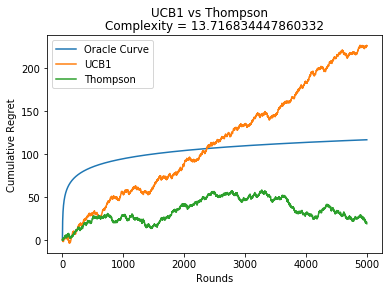

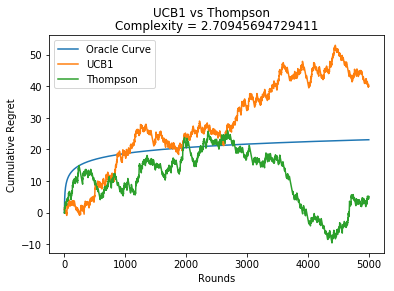

In [18]:
MAB1 = MAB([0.3,0.25,0.2,0.1])
MAB2 = MAB([0.7,0.9,0.25,0.55])
nb_arms = len(MAB1)
p1,p2 = [el.mean for el in MAB1],[el.mean for el in MAB2]
mu_max1, mu_max2 = np.max(p1), np.max(p2)
C1,C2 = complexity(p1), complexity(p2)
T=5000
#Cumulative expected regret UCB1, Thompson Sampling and Naive strategy
[rew1,draws1]=UCB1(T, MAB1,np.sqrt(3))
reg1 = mu_max1 * np.arange(1, T + 1) - np.cumsum(rew1)
[rew2,draws2]=TS(T, MAB1)
reg2 = mu_max1 * np.arange(1, T + 1) - np.cumsum(rew2)
plt.figure(1)
x = np.arange(1, T+1)
plt.plot(x,C1*np.log(x), label='Oracle Curve')
plt.plot(x, reg1, label='UCB1')
plt.plot(x, reg2, label='Thompson')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.suptitle('UCB1 vs Thompson')
plt.title('Complexity = '+str(C1))
plt.legend()
plt.show()
#Cumulative expected regret UCB1, Thompson Sampling and Naive strategy
[rew3,draws3]=UCB1(T, MAB2,np.sqrt(3))
reg3 = mu_max2 * np.arange(1, T + 1) - np.cumsum(rew3)
[rew4,draws4]=TS(T, MAB2)
reg4 = mu_max2 * np.arange(1, T + 1) - np.cumsum(rew4)
plt.figure(2)
x = np.arange(1, T+1)
plt.plot(x,C2*np.log(x), label='Oracle Curve')
plt.plot(x, reg3, label='UCB1')
plt.plot(x, reg4, label='Thompson')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.autoscale(enable=True, axis='both', tight=None)
plt.suptitle('UCB1 vs Thompson')
plt.title('Complexity = '+str(C2))
plt.legend()
plt.show()


<div class="alert alert-success">
We can see that for a high complexity (C=13.71) the UCB1 regret diverges to infinity when the number of Rounds increases while the Thompson regret curve stay below the Oracle Curve when T become large.

For low complexity , we can see that the Thompson and UCB1 regret curves fluctuate close to 0 and the thompson regret curve is below the oracle curve for large T.

We can then conclude that for high complexity the Thompson Sampling is performing better than the UCB1

Also, we can notice that Lai and Robbins' is in fact a lower bound on the UCB1 mean cumulative regret after a certain round ( $T \rightarrow \infty$). For the first problem, this occurs after 1700 rounds, for the second one, its occurs after 3400 rounds. However, the Thompson Sampling mean cumulative regret is always under the bound. This can be explained by the fact that T is not big enough.
</div>

<div class="alert alert-info">1.2.1: Using the other classes of arms, build a MAB with arms that are not only Bernoulli. Why non-parametric? because we
consider a MAB with different classes of arms (which can even be non parametric).</div>

In [22]:
arm1 = arms.ArmBernoulli(0.54, random_state=312414)
arm2 = arms.ArmBeta(3,7, random_state=312414)
arm3 = arms.ArmExp(4, random_state=312414)
arm4 = arms.ArmFinite(np.array([0.1,0.2,0.5,0.85]),np.array([0.2,0.1,0.4,0.3]), random_state=312414)

T=6000

MAB = [arm1, arm2, arm3, arm4]

# bandit : set of arms
nb_arms = len(MAB)
means = [el.mean for el in MAB]

# Display the means of your bandit (to find the best)
mu_max = np.max(means)
print('means: {}'.format(means))

means: [0.54, 0.3, 0.23134263963622598, 0.495]


<div class="alert alert-info"> 1.2.2 Propose an adaptation of Thompson Sampling to handle non-binary rewards and implement it together with UCB1 on
your bandit model (see e.g., [Agrawal and Goyal, 2012]).</div>

In [23]:
def simulateRV(probabilities,values,n):
    bins = np.add.accumulate(probabilities)
    return values[np.digitize(np.random.rand(n),bins)]

def non_binary_rews_TS(T,MAB):
    rew=[]
    draws=[]
    N=np.array([0]*len(MAB))
    S=[0]*len(MAB)
    for k in range(T):
        A=[np.random.beta(S[a]+1,N[a]-S[a]+1) for a in range(len(MAB))]
        a=np.argmax(A)
        sample=1*MAB[a].sample()[0]
        proba=np.array([1-sample,sample])
        values=np.array([0,1])
        r=simulateRV(proba,values,1)
        draws.append(a)
        rew.append(r)
        N[a]+=1
        S[a]+=r
    return [rew,draws]

<div class="alert alert-success">To adapt the Thompson method to a non-binary reward, for the reward $r_t$ which is a float in [0,1] we simulate a bernoulli sample of parameter $r_t$ as a binary reward for each trial.

In this case, the notion of complexity does not really make sense because the function kl has been defined for two Bernoulli distributions.

The Burnetas and Katehakis have extended the regret lower bound to non binary problems with a adapted complexity which
has the form $C(p) =\frac{1}{D_k(θ)}$ where $D_{k}=inf_{v_{k}^* \in \theta_{k} :  E(v_k)>p*}KL(v_k,v_k*)$ where $\theta=(v_1,v_2,v_3,v_4)$ with $v_i$ is a real-valued measure that represents the distribution reward of arm k and where KL is the Kullback-Leibler
divergence and $\Theta_k$ is the set of possible reward distributions of arm k.
</div>

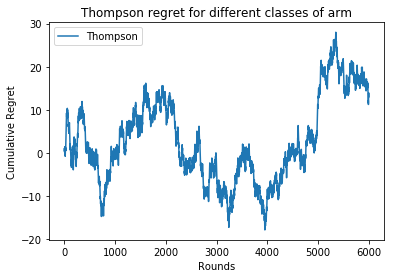

In [24]:
[rew3,draws3]=non_binary_rews_TS(T,MAB)
reg3 = mu_max * np.arange(1, T + 1) - np.cumsum(rew3)
plt.figure(1)
x = np.arange(1, T+1)
plt.plot(x, reg3, label='Thompson')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Thompson regret for different classes of arm')
plt.legend()
plt.show()

<div class="alert alert-success">we can see that the Thompson regret curve fluctuate close to 0</div>

<div class="alert alert-info">Q3: Implement the LinUCB algorithm for the provided MovieLens problem. Compare the performance against the following
            algorithms (consider a horizon T = 6000)</div>

Simulating Eps_Greedy: 100%|██████████| 50/50 [29:06<00:00, 34.93s/it]


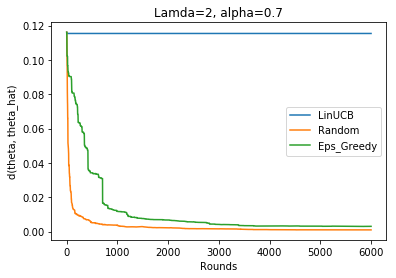

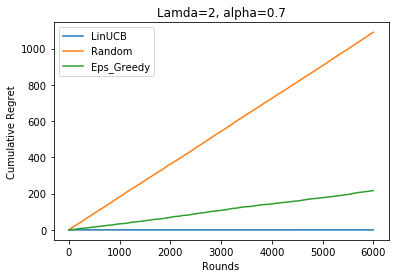

In [177]:
from linearmab_models import ToyLinearModel, ColdStartMovieLensModel
import matplotlib.pyplot as plt
from tqdm import tqdm

random_state = np.random.randint(0, 24532523)
model = ToyLinearModel(
    n_features=8,
    n_actions=20,
    random_state=random_state,
    noise=0.1)

model = ColdStartMovieLensModel(random_state=random_state,noise=0.1)

n_a = model.n_actions
d = model.n_features

T = 6000


nb_simu = 50 # you may want to change this!

##################################################################
# define the algorithms
# - Random
# - Linear UCB
# - Eps Greedy
# and test it!
def linUCB(Z,y,lamda,alpha):
    features=model.features
    A=np.linalg.inv(np.dot(np.array(Z).T,Z)+lamda*np.eye(d))
    if (len(Z)==0):
        theta=[0]*d
    else:
        theta=np.dot(np.dot(A,np.array(Z).T),y)
    beta=alpha*np.sqrt([np.dot(np.dot(phi,A),phi.T) for phi in features])
    B=np.array([float(np.dot(features[i].T,theta)+beta[i]) for i in range(len(beta))])
    action=np.argmax(B)
    return [action,theta]
def Random(Z,y,lamda):
    a_t=np.random.randint(n_a)
    A=np.linalg.inv(np.dot(np.array(Z).T,Z)+lamda*np.eye(d))
    if (len(Z)==0):
        theta=[0]*d
    else:
        theta=np.dot(np.dot(A,np.array(Z).T),y)
    return [a_t,theta]
def Eps_Greedy(Z,y,lamda,epsilon=0.2):
    A=np.linalg.inv(np.dot(np.array(Z).T,Z)+lamda*np.eye(d))
    if (len(Z)==0):
        theta=[0]*d
    else:
        theta=np.dot(np.dot(A,np.array(Z).T),y)
    R=[]
    for i in range(n_a):
        R.append(model.reward(i))
    i_max=np.argmax(R)
    a=np.random.random()
    if (a<epsilon):
        a_t=np.random.randint(0,n_a)
    else:
        a_t=i_max
    return [a_t,theta]

#simulations:
nb_simu = 50
dic={'LinUCB': lambda Z,y: linUCB(Z,y,2,0.7),'Random':lambda Z,y: Random(Z,y,2),'Eps_Greedy':\
    lambda Z,y: Eps_Greedy(Z,y,2)}
for key,value in dic.items():
    i=0
    for k in tqdm(range(nb_simu), desc="Simulating {}".format(key)):
        Z=[]
        y=[]
        regret = np.zeros((nb_simu, T))
        norm_dist = np.zeros((nb_simu, T))
        for t in range(T):
            [a_t,theta_hat]=value(Z,y) # algorithm picks the action
            r_t = model.reward(a_t) # get the reward
            Z.append(model.features[a_t])
            y+=[r_t]
            # store regret
            regret[k, t] = model.best_arm_reward() - r_t
            norm_dist[k, t] = np.linalg.norm([theta_hat[i]-model.real_theta[i] for i in range(
len(theta_hat))])
##################################################################

regret = np.zeros((nb_simu, T))
norm_dist = np.zeros((nb_simu, T))

for k in tqdm(range(nb_simu), desc="Simulating {}".format(alg_name)):

    for t in range(T):
        a_t = ...  # algorithm picks the action
        r_t = model.reward(a_t) # get the reward

        # do something (update algorithm)

        # store regret
        regret[k, t] = model.best_arm_reward() - r_t
        norm_dist[k, t] = np.linalg.norm(theta_hat - model.real_theta, 2)

# compute average (over sim) of the algorithm performance and plot it
mean_norms = np.mean(norm_dist,axis=0)
mean_regret = np.mean(regret,axis=0)

plt.figure(1)
plt.subplot(121)
plt.plot(mean_norms, label=alg_name)
plt.ylabel('d(theta, theta_hat)')
plt.xlabel('Rounds')
plt.legend()

plt.subplot(122)
plt.plot(mean_regret.cumsum(), label=alg_name)
plt.ylabel('Cumulative Regret')
plt.xlabel('Rounds')
plt.legend()
plt.show()

<div class="alert alert-success">
<b>alpha=0.7 and lambda=2.</b>
<p>The cumulative Regret curve of the LinUCB is below the regret curves of epsilon-greedy and random methods, but the estimated theta doesn't converge to the true one for the LinUCB.</p>

The estimated theta for LINUCB converges rapidly to 0.12 (in about 50 iterations) and the two other methods (random et eps_greedy) converge after respectively 2500 and 3500 iterations.
</div>

Simulating Eps_Greedy: 100%|██████████| 20/20 [10:49<00:00, 32.50s/it]


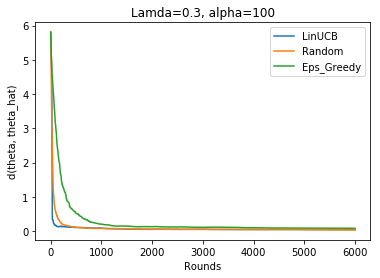

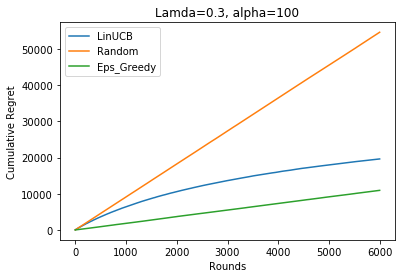

In [195]:
 
##################################################################
T=6000
nb_simu = 20

dic={'LinUCB': lambda Z,y: linUCB(Z,y,0.3,100),'Random':lambda Z,y: Random(Z,y,0.3),'Eps_Greedy':\
     lambda Z,y: Eps_Greedy(Z,y,0.3)}
for key,value in dic.items():
    i=0
    regret = np.zeros((3,nb_simu, T))
    norm_dist = np.zeros((3,nb_simu, T))
    for k in tqdm(range(nb_simu), desc="Simulating {}".format(key)):
        Z=[]
        y=[]

        for t in range(T):
            [a_t,theta_hat]=value(Z,y) # algorithm picks the action
            r_t = model.reward(a_t) # get the reward
            Z.append(model.features[a_t])
            y+=[r_t]

            # store regret
            regret[i,k, t] = model.best_arm_reward() - r_t
            norm_dist[i,k, t] = np.linalg.norm([theta_hat[i]-model.real_theta[i] for i in range(len(theta_hat))])
    i+=1
            # compute average (over sim) of the algorithm performance and plot it
    mean_norms = np.mean(norm_dist[0],axis=0)
    mean_regret = np.mean(regret[0],axis=0)
    plt.figure(1)
    plt.plot(mean_norms, label=key)
    plt.ylabel('d(theta, theta_hat)')
    plt.title('Lamda=0.3, alpha=100')
    plt.xlabel('Rounds')
    plt.legend()

    plt.figure(2)
    plt.plot(mean_regret.cumsum(), label=key)
    plt.ylabel('Cumulative Regret')
    plt.title('Lamda=0.3, alpha=100')
    plt.xlabel('Rounds')
    plt.legend()
plt.show()    




 <div class="alert alert-success">
 The above curves show that the random strategy converges faster towards the real $\theta$ since there is a lot of exploration (repeatedly pulls all the arms). However the regret is very high compared to the two other methods because of the lack of exploitation(pulling a lot of suboptimal arms).
 
 The eps-greedy has more exploitation (because it pulls optimal arms with proba $1-\epsilon$, so the regret is lower than the random's one. However, the convergence towards the real $\theta$ is slower.
 
for small values of $\alpha$, LinUCB algo does not converge towards the real $\theta$, we need to use higher values to get close to the real $\theta$.
 </div>